In [1]:
import yaml
import pprint
pp = pprint.PrettyPrinter(indent=4)
with open('../config.yaml', 'r') as f:
    config = yaml.load(f)
config['applications'].append('guillotina_processing')
pp.pprint(config)

{   'address': 8081,
    'aiohttp_settings': {'client_max_size': 20971520},
    'applications': [   'guillotina_swagger',
                        'guillotina_cms',
                        'guillotina_dbusers',
                        'guillotina_elasticsearch',
                        'guillotina_rediscache',
                        'guillotina_processing'],
    'auth_extractors': [   'guillotina.auth.extractors.CookiePolicy',
                           'guillotina.auth.extractors.BearerAuthPolicy',
                           'guillotina.auth.extractors.BasicAuthPolicy',
                           'guillotina.auth.extractors.WSTokenAuthPolicy'],
    'auth_token_validators': [   'guillotina.auth.validators.SaltedHashPasswordValidator',
                                 'guillotina.auth.validators.JWTValidator'],
    'cors': {   'allow_credentials': True,
                'allow_headers': ['*'],
                'allow_methods': [   'GET',
                                     'POST',
      

In [2]:
from guillotina.factory import make_app

app = await make_app(settings=config)

In [3]:
root = app.root
db = await root.get('db')
from guillotina.contentapi import ContentAPI

async with ContentAPI(db) as api:
    folder = await api.get('cms/articles')

In [4]:
await folder.async_len()

2579

In [5]:
import sys
i = 0
async for article in folder.async_values():
    i += 1
    print('{} articles'.format(i), end='\r')
    sys.stdout.flush()

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [7]:
from guillotina_processing.utils import get_index_values
async with ContentAPI(db) as api:
    container = await api.get('cms')
    labels = await get_index_values('tags', container)
    print(labels)


['sports', 'business']


In [8]:
# Calculate Vocabulary
from guillotina_processing.vocabulary import build_vocabulary

search_dict = {'type_name': 'Document', 'path__starts': 'articles'}
async with ContentAPI(db) as api:
    container = await api.get('cms')
    vocabulary = await build_vocabulary('testing', container, container=container, search=search_dict, max_words=10000)
len(vocabulary.dictionary)

10004

In [9]:
from guillotina_processing.keras.generator import DataTextGenerator
from guillotina_processing.interfaces import IIteratorSearch

async with ContentAPI(db) as api:
    list_ids = []
    iterator = IIteratorSearch(container)
    iterator.set_container(container)
    iterator.set_search(search_dict)
    async for id_ in iterator(ids=True):
        list_ids.append(id_)

# Parameters
params = {'dim': 256,
          'batch_size': 64,
          'n_classes': len(labels),
          'shuffle': True}

ids = np.array(list_ids)
np.random.shuffle(ids)
training_count = int(len(ids)*0.9)
training, test = ids[:training_count], ids[training_count:]

training_generator = DataTextGenerator(training, labels, vocabulary, **params)
validation_generator = DataTextGenerator(test, labels, vocabulary, **params)


Using TensorFlow backend.


In [10]:
len(test), len(labels), len(list_ids)

(258, 2, 2579)

In [11]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
from tensorflow import keras

vocab_size = len(vocabulary.dictionary)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 8))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(2, activation=tf.nn.sigmoid))

model.summary()
    
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           80032     
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 80,210
Trainable params: 80,210
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model on dataset
from guillotina_processing.keras.training_generator import fit_generator
async with ContentAPI(db) as api:
    tt = await api.get_transaction()
    history = await fit_generator(
        model, generator=training_generator,
        validation_data=validation_generator,
        epochs=10)

Epoch 1/10
36/36 [==============================] - 9s 262ms/step - loss: 0.6909 - acc: 0.5386 - val_loss: 0.6866 - val_acc: 0.6113
Epoch 2/10
36/36 [==============================] - 9s 250ms/step - loss: 0.6813 - acc: 0.6161 - val_loss: 0.6721 - val_acc: 0.6641
Epoch 3/10
36/36 [==============================] - 9s 252ms/step - loss: 0.6570 - acc: 0.7372 - val_loss: 0.6390 - val_acc: 0.7520
Epoch 4/10
36/36 [==============================] - 9s 260ms/step - loss: 0.6068 - acc: 0.8266 - val_loss: 0.5802 - val_acc: 0.8105
Epoch 5/10
36/36 [==============================] - 9s 257ms/step - loss: 0.5296 - acc: 0.8802 - val_loss: 0.4980 - val_acc: 0.8770
Epoch 6/10
36/36 [==============================] - 10s 288ms/step - loss: 0.4346 - acc: 0.9282 - val_loss: 0.4058 - val_acc: 0.9258
Epoch 7/10
36/36 [==============================] - 11s 310ms/step - loss: 0.3391 - acc: 0.9586 - val_loss: 0.3195 - val_acc: 0.9668
Epoch 8/10
36/36 [==============================] - 10s 289ms/step - loss:

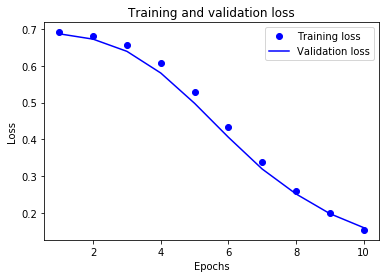

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


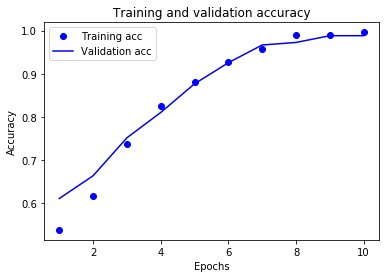

In [14]:
plt.clf()   # clear figure
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
news_content = """HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese business stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing growth.Hong Kong rose 1.07 percent, closing 252.78 points higher at 23857.82.Seoul closed up 0.57 percent, rising 10.85 points to 1,926.44, while Sydney gained 0.46 percent, or 24.89 points, to close at 5,435.9.Singapore edged up 0.19 percent, gaining 6.39 points to 3,371.54.Markets in mainland China, Japan, Taiwan, New Zealand, the Philippines, and Thailand remained closed for holidays.With mainland bourses shut until January 5, shares in Chinese developers and financial companies surged in Hong Kong, stoked by hopes that Beijing could ease monetary policy to support lagging growth in the world´s second-largest economy.China Vanke, the country´s biggest developer by sales, leapt 10.8 percent and the People´s Insurance Company (Group) of China Ltd. was up 5.51 percent in afternoon trading.Train-builders CSR Corp. and China CNR Corp. soared -- CSR by 16.5 percent and China CNR by 16.0 percent -- extending gains on December 31 after they announced a merger agreement.China´s manufacturing growth dropped in December to its lowest level of 2014, an official survey showed Thursday, as the sector struggles with weak domestic demand.China´s official Purchasing Managers´ Index (PMI) released by the National Bureau of Statistics (NBS) came in at 50.1 last month, down from 50.3 recorded in November.The index, which tracks activity in factories and workshops, is considered a key indicator of the health of China´s economy, a major driver of global growth. A figure above 50 signals expansion, while anything below indicates contraction.""Growth momentum is still insufficient,"" NBS said in a statement. - Investors eye US factory data -On forex markets the dollar extended gains ahead of the release of American factory data due later on Friday and following a steady stream of good news from the world´s biggest economy.The dollar bought 120.44 yen, compared to 119.44 yen in final 2014 trading on Wednesday.Wall Street toasted a banner year in 2014, with US equity markets finishing near all-time highs.The euro meanwhile slipped amid growing expectations that the European Central Bank, which meets on January 22, will start buying sovereign bonds. The single currency bought $1.2061 compared to $1.2160 in pre-holiday trade.The ECB has already used several tools to push inflation in member nations back up to the 2.0 percent annual rate it regards as healthy, including asset purchases and making cheap loans available to banks.It is also examining the possibility of large-scale purchases of sovereign debt -- so-called quantitative easing (QE) -- to help jump-start the European Union´s moribund economy.Oil prices rose on Friday, with US benchmark West Texas Intermediate for February delivery rising 44 cents to $54.07 and Brent crude for February gaining 18 cents to $57.51.""The gains in Asian trading are likely because of the positive US crude stockpiles data released on Wednesday,"" Daniel Ang, investment analyst at Phillip Futures in Singapore, told AFP.US crude reserves fell by 1.8 million barrels in the week to December 26, the US Energy Information Administration said in its last petroleum report for 2014 released on Wednesday, boosting prices that lost nearly half their value in the second half of the year.There is growing speculation that the slide in global oil prices -- the biggest since the financial crisis in 2008 -- may have been excessive.""If we do see some supply-side responses, or even if they´re anticipated over the course of this first quarter of the year, we might find that oil has in fact bottomed,"" Michael McCarthy, a chief strategist at CMC Markets in Sydney, told Bloomberg.Gold was at $1,182.36 an ounce, compared with $1,199.00 in end-of-year trading on Wednesday.In other markets:-- Jakarta ended up 0.30 percent, or 15.82 points, at 5,242.77.Coal firm Indo Tambangraya Megah gained 3.41 percent to 15,900 rupiah, while miner Aneka Tambang slipped 1.88 percent to 1,045 rupiah.-- Malaysia´s main stock index shed 0.48 percent, or 8.48 points, to close at 1,752.77.Malayan Banking lost 0.55 percent to 9.12 ringgit, Public Bank slipped 0.44 percent to 18.22 while Top Globe added 1.77 percent 4.60 ringgit.-- Singapore rose 0.16 percent, or 5.44 points, to 3,370.59.Agribusiness company Wilmar International gained 0.93 percent to Sg$3.27 while real estate developer Capitaland dipped 0.30 percent to Sg$3.30.-- Mumbai gained 1.38 percent, or 380.36 points, to end at 27,887.90.Housing Development Finance Corp rose 4.30 percent to 1,171.80 rupees, while Mahindra & Mahindra fell 0.92 percent to 1,224.80 rupees. (AFP) """

news2_content = """A strong Q3 performance has boosted expectations of the SAR taking the top spot. In defiance of the subdued market environment that has seen better days, Hong Kong is well-positioned to claim the spot as the highest performing global stock exchange by end-2018 on the back of blockbuster listings and an IPO pipeline that’s fit to burst. KPMG China has revised its IPO fundraising forecast for Hong Kong from $250b to over $300b by end-2018 after a strong performance in Q3 that bucked the increasingly bearish tone of global market rattled by trade jitters. Also read: Hong Kong raises record US$19.2b in summer IPO haul The Main Board hauled $190b in proceeds from 40 new listings in Q3 alone, smashing the full-year 2017 record of $122.6b thanks to China Tower’s mega $54.3b IPO. The GEM also booked a healthy performance after raising $4.6b from 67 new listings in the first three quarters of the year. Also read: Meituan Dianping raises US$4.2b in IPO priced at high end Moving forward, IPO proceeds in the Main Board are expected to hit $238.2b in the first nine months of 2018, almost triple the amount raised a year ago, according to KPMG. The number of IPOs is forecasted to balloon by 73% to 88, whilst the average deal size will also increase to $2.71b. The buoyant forecast is boosted by sweeping bourse reforms implemented by the stock exchange operator which paved the way for new economy firms and biotech firms with no record of profitability to list. “Three pre-revenue biotech companies and two with weighted voting right structures completed their IPOs by the end of Q3. We expect to see six to ten pre-revenue biotech companies list by the end of 2018 as the trend continues,” Maggie Lee, Head of Capital Markets Development Group, Hong Kong, KPMG China said in a statement. Also read: US biotech firms seeking higher valuations rush to Hong Kong The high-end manufacturing and high-tech companies are expected to retain the lead in terms of total transactions and proceeds alongside the financial services sector which is expected to eat up market share by Q4, added Louis Lau, partner, capital markets advisory group at KPMG China."""

sports_content = """A spectator struck by a golf ball at last weekend's Ryder Cup said she has lost the sight in her right eye and is planning to sue organisers. Corine Remande, 49, had travelled to France from Egypt with her husband Raphael to watch the biennial showdown between Europe and the United States, held at Le Golf National club in Saint-Quentin-en-Yvelines just outside Paris. But the avid golf fan's holiday ended abruptly when a tee shot from American Brooks Koepka veered left, landed among a crowd of spectators on the sixth hole and hit her in the right eye. US Open champion Koepka swiftly apologised to Remande following the incident. Remande however told AFP on Monday she planned to seek legal action, claiming there was no warning from officials before the ball hurtled into the gallery."""



In [16]:
from guillotina_processing.utils import cleanup_text
vector = [vocabulary.dictionary.get(word,2) for word in cleanup_text(sports_content)]
vector2 = [vocabulary.dictionary.get(word,2) for word in cleanup_text(news_content)]
vector3 = [vocabulary.dictionary.get(word,0) for word in cleanup_text(news2_content)]

prediction = model.predict(np.array(vector))
print('sports_content is: %s' % labels[np.argmax(prediction[0])])

prediction = model.predict(np.array(vector2))
print('news_content is: %s' % labels[np.argmax(prediction[0])])

prediction = model.predict(np.array(vector3))
print('news2_content is: %s' % labels[np.argmax(prediction[0])])


sports_content is: business
news_content is: sports
news2_content is: business
